In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
pd.set_option("display.max_row",6000)
pd.set_option("display.max_column",200)
pd.set_option("display.precision", 2)

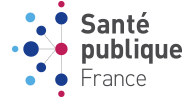

# <span class="bg-primary">Analyse exploratoire des données<span>

# <span class="bg-danger">Introduction<span>
    
L'idée d'application dont nous testerons la faisabilité portera sur __l'alimentation en cas de diabète__. Notre application se voudra clairement informative et simple d'utilisation. Elle consistera à donner aux personnes diabétiques des informations sur les produits de la base de données d'_Open Food Facts_ les plus pertinentes possibles et les mieux adaptées au régime alimentaire préconisé aux diabétiques. 

# <span class="bg-danger">Sommaire<span>
    
__<span class="bg-info">1.<span>__ __Chargement__ du jeu de données nettoyé
  
__<span class="bg-info">2.<span>__ __Informations générales__ sur le jeu de données nettoyé
    
__<span class="bg-info">3.<span>__ __Analyse univariée__ du jeu de données nettoyé

__<span class="bg-warning">3_1.<span>__ Variables qualitatives nominales
___
__<span class="bg-warning">3_2.<span>__ Variable qualitative ordinale
___
__<span class="bg-warning">3_3.<span>__ Variables quantitatives
___
__<span class="bg-warning">3_4.<span>__ Variable quantitative discrète
___
__<span class="bg-warning">3_5.<span>__ Variables quantitatives continues
___
__<span class="bg-info">4.<span>__ __Analyse bivariée__ 

__<span class="bg-info">5.<span>__ __Analyse multivariée__

__<span class="bg-info">6.<span>__ __Conclusion__   

## <span class="bg-info"> 1. Chargement du jeu de données nettoyé<span>

In [3]:
data = pd.read_csv('data_application_smart.csv',sep = '\t',low_memory=False )

## <span class="bg-info"> 2. Informations générales sur le jeu de données nettoyé<span>

In [4]:
data.columns

Index(['product_name', 'categories', 'image_url', 'stores', 'countries_tags',
       'nutriscore_grade', 'nutrition_score_fr_100g', 'nova_group',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'ratio_sucre'],
      dtype='object')

In [5]:
data.describe().transpose();

In [6]:
data.describe(exclude=[np.number]).transpose();

## <span class="bg-info"> 3. Analyse univariée du jeu de données nettoyé<span>

### <span class="bg-warning">3_1<span> Variables qualitatives nominales

_Variable "categories", "product_name", "stores"_

In [7]:
data['categories'] = data['categories'].fillna("").apply(lambda s: s.split(',') if s != "" else [])
categories_compteurs = {}
for lst in data['categories']:
    for categories in lst:
        if categories:
            if categories in categories_compteurs:
                categories_compteurs[categories] += 1
            else:
                categories_compteurs[categories] = 1
sorted_categories_compteurs = sorted(categories_compteurs, key=categories_compteurs.get, reverse=True)

nombre_fois_present = data['categories'].value_counts()
modalites = nombre_fois_present.index
tab = pd.DataFrame(modalites, columns = ['categories'])
tab['Nombre'] = nombre_fois_present.values
tab['Fréquence'] = tab['Nombre']/len(data)
tab.head(10)

,categories,Nombre,Fréquence
0,[Snacks],15760,0.11
1,"[Dairies, Fermented foods, Fermented milk pr...",6867,0.05
2,"[Snacks, Sweet snacks, Confectioneries]",6367,0.04
3,"[Groceries, Sauces]",5844,0.04
4,"[Desserts, Frozen foods, Frozen desserts]",5460,0.04
5,"[Snacks, Sweet snacks, Biscuits and cakes, ...",5037,0.04
6,"[Plant-based foods and beverages, Plant-based...",4376,0.03
7,"[Plant-based foods and beverages, Plant-based...",4352,0.03
8,[Frozen foods],4150,0.03
9,"[Biscuits and cakes, Cakes]",3056,0.02


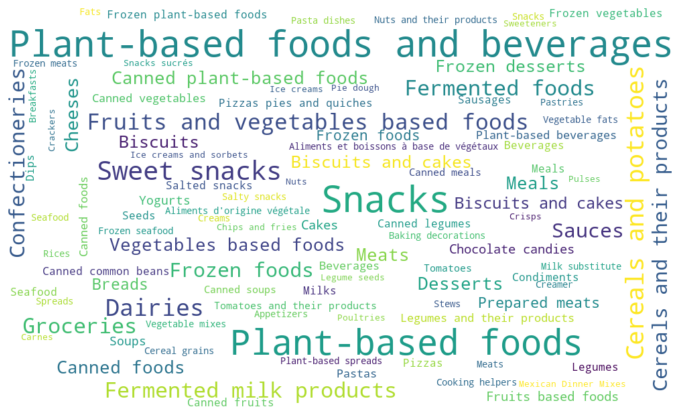

In [8]:
from wordcloud import WordCloud, ImageColorGenerator
wordcloud = WordCloud(width=1000, height=600, background_color="white", max_words=100).generate_from_frequencies(categories_compteurs)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

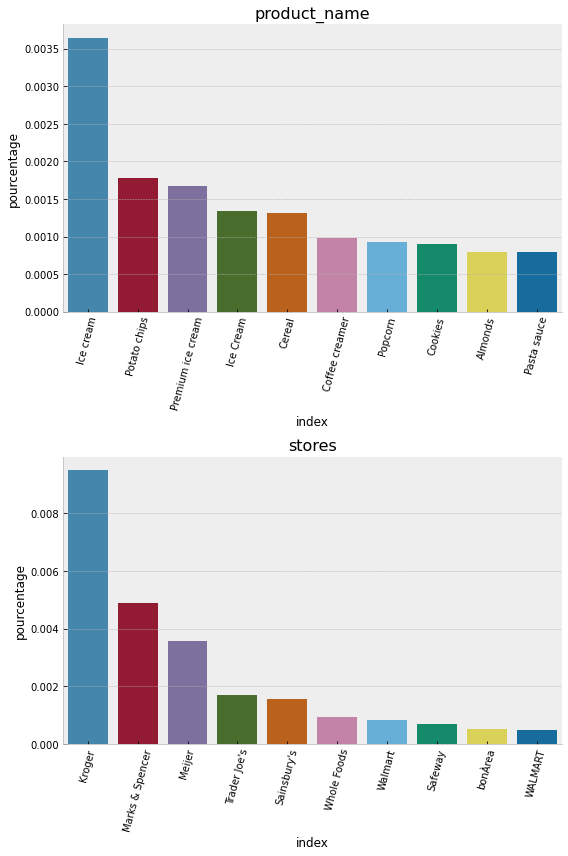

In [9]:
variables_qualitatives = ['product_name', 'stores']
import matplotlib.style as style
style.use('bmh')

fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax_list = [ax1,ax2]

axes_count = 0
for c in variables_qualitatives:
    counts = data[c].value_counts()
    counts = counts.to_frame(name='counts').reset_index()
    counts['pourcentage'] = counts['counts']/(data.shape[0])
    counts.drop(['counts'], axis = 1, inplace = True)
    counts_ten = counts[0:10]
       
    g = sns.barplot(x='index', y='pourcentage', data=counts_ten, ax=ax_list[axes_count])
    g.set_xticklabels(rotation = 75, labels= counts_ten['index'])
    sns.despine()
    ax_list[axes_count].set_title(c, fontsize=16)
    axes_count += 1
plt.tight_layout()
plt.show()

Les variables qualitatives nominales nous permettent d'émettre des hypothèses, que nous vérifierons ci-dessous, sur la répartition des produits les plus fréquents de notre jeu de données : leur répartition dans le nutriscore devrait être majoritaire dans les catégories D et E, et 3 et 4 dans la classification Nova qui indique le degré de transformation des aliments. 

Notons que les chaînes de supermarché majoritairement représentées sont situées hors hexagone. Cette variable sera peu utile à nos utilsateurs français.

### <span class="bg-warning">3_2<span> Variable qualitative ordinale

_Variable nutriscore_grade_ Nutriscore avec __notes de A à E__

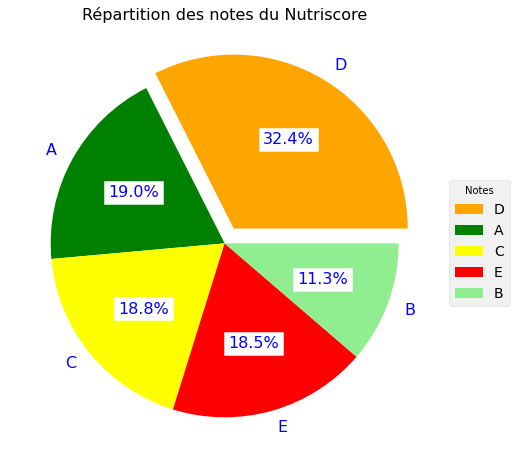

In [10]:
plt.figure(figsize=(8,8))
plt.title('Répartition des notes du Nutriscore', size=16)
wedges, texts, autotexts = plt.pie(data.nutriscore_grade.value_counts().values, labels = data.nutriscore_grade.value_counts().index.str.upper(),autopct='%1.1f%%', colors = ['orange', 'green', 'yellow', 'red', 'lightgreen'],textprops={'fontsize': 16, 'color' : 'b', 'backgroundcolor' : 'w'},explode =(0.1, 0,0,0,0))
ax = plt.gca()
ax.legend(wedges, data.nutriscore_grade.value_counts().index.str.upper(),title="Notes",loc="center left",fontsize=14,bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Notes majoritaires : D, puis A et C.

### <span class="bg-warning">3_3<span> Variables quantitatives
   
Vue générale de leur répartition grâce aux histogrammes

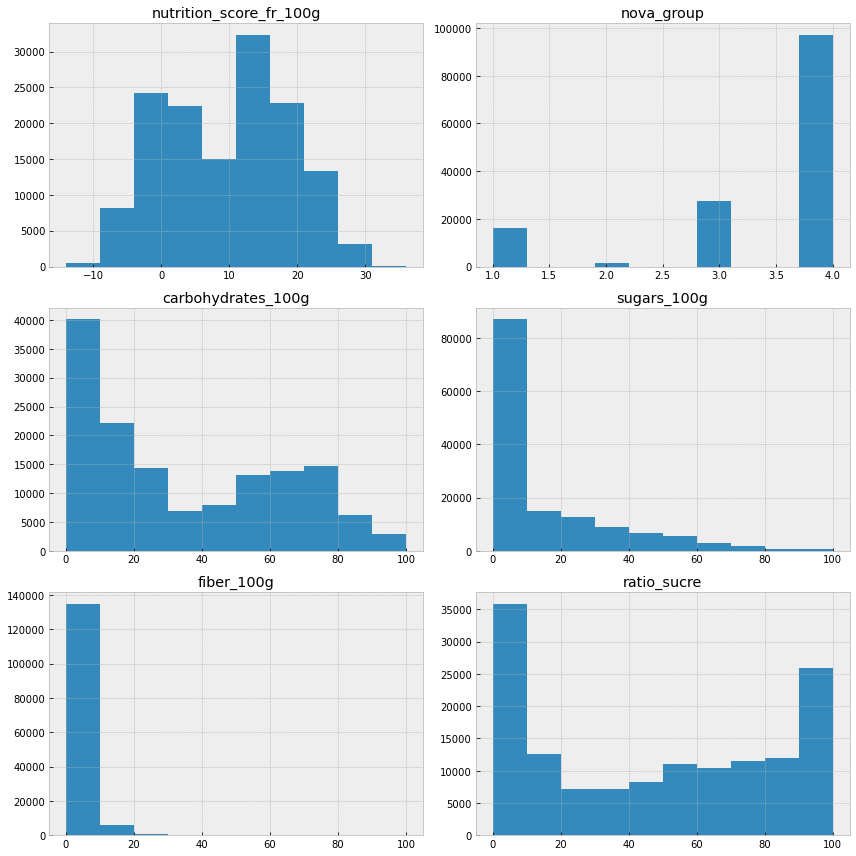

In [11]:
num_variables = data.select_dtypes(include=[np.number]).columns
data.loc[:, num_variables].hist(figsize=(12, 12))
plt.tight_layout()

### <span class="bg-warning">3_4<span> Variables quantitatives discrètes

_Classification Nova_

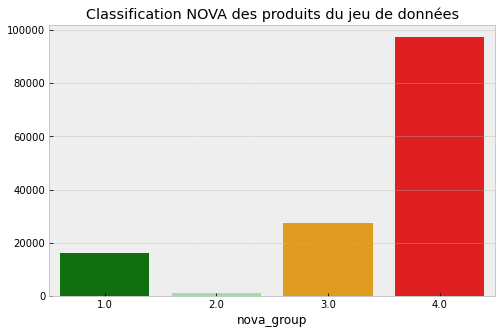

In [12]:
plt.figure(figsize = [8,5])
sns.color_palette(['green', 'lightgreen', 'orange','red'])
sns.countplot(data=data, x='nova_group', palette = sns.color_palette(['green', 'lightgreen', 'orange','red'], 8))
plt.ylabel('')
plt.title('Classification NOVA des produits du jeu de données')
plt.show()

L'hypothèse formulée est vérifiée : les produits du jeu de données sont majoritairement classés 3 et 4. Ce sont des aliments très transformés, voire ultra-transformés (AUT).

_Variable 'nutrition_score_fr_100g'_

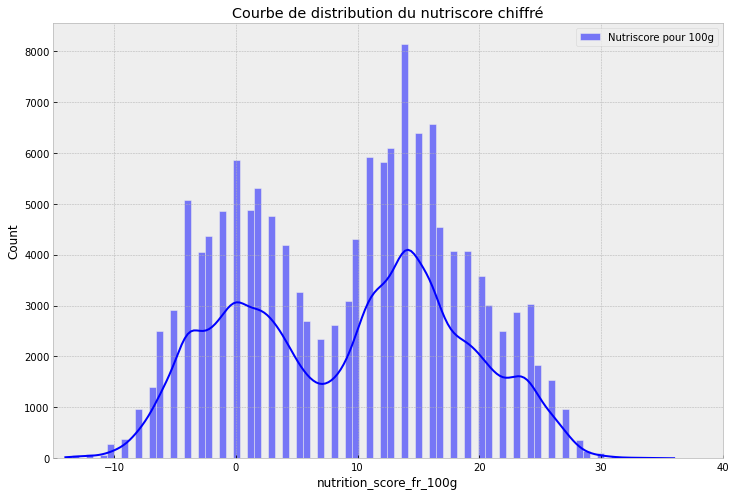

In [13]:
# Courbe de distribution du nutriscore
plt.figure(figsize=(12,8)) # taille figure 12:8

sns.histplot(data['nutrition_score_fr_100g'],label="Nutriscore pour 100g",kde=True)

plt.title("Courbe de distribution du nutriscore chiffré") # titre
plt.legend() # légendes
# Contrôles des limites de x et y 
plt.xlim(-15, 40)
plt.show()

Notes possibles de -18 à 40. Pour notre échantillon : amplitude de -14 à 36.

Distribution bimodale en 0 et en 15.

In [14]:
data['nutrition_score_fr_100g'].describe()

count    141990.00
mean          9.17
std           9.19
min         -14.00
25%           1.00
50%          11.00
75%          16.00
max          36.00
Name: nutrition_score_fr_100g, dtype: float64

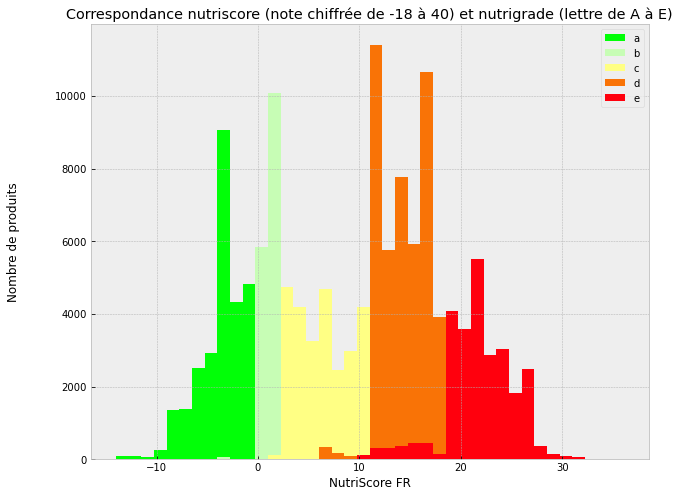

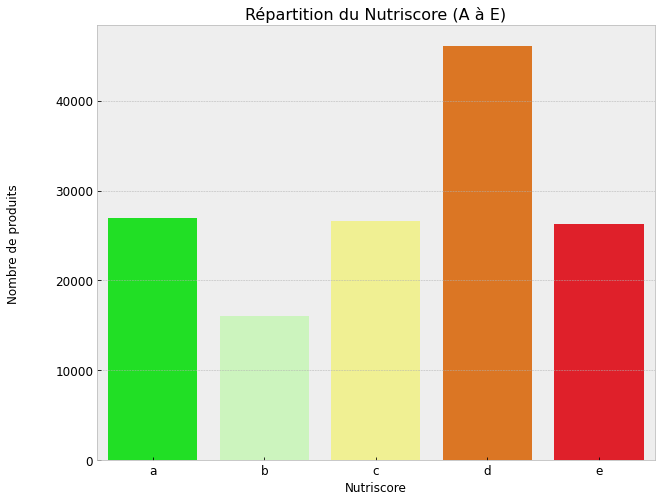

In [15]:
color = ["bright green", "pale green", "pale yellow", "orange", "bright red"]
sns.set_palette(sns.xkcd_palette(color))
nutrigrade_colors= ["xkcd:bright green", "xkcd:pale green", "xkcd:pale yellow", "xkcd:orange", "xkcd:bright red"]
plt.rcParams["figure.figsize"] = (10,8)
df_plot = pd.DataFrame()
for grade in enumerate('abcde'):
    df_grade = data[data['nutriscore_grade'] ==grade[1]]['nutrition_score_fr_100g']
    df_grade = df_grade.reset_index().drop('index', axis = 1)
    df_grade = df_grade.rename(columns = {'nutrition_score_fr_100g': grade[1]})
    df_plot = pd.concat([df_plot, df_grade], axis = 1, sort=True)
        
plot = df_plot.plot.hist(bins= 40,title = 'Correspondance nutriscore (note chiffrée de -18 à 40) et nutrigrade (lettre de A à E)',color =nutrigrade_colors)
plot = plt.xlabel ('NutriScore FR', fontsize=12)
plot = plt.ylabel('Nombre de produits',rotation=90, labelpad=35, fontsize=12)
plt.show()
    
ax = sns.countplot(x=data['nutriscore_grade'] , order= 'abcde')
silent=plt.xticks(fontsize=12)
silent=plt.yticks(fontsize=12)
silent = ax.set_title('Répartition du Nutriscore (A à E)' ,  fontsize=16)
silent = ax.set_xlabel('Nutriscore',  fontsize=12)
silent = ax.set_ylabel('Nombre de produits', rotation=90, labelpad=35, fontsize=12)

### <span class="bg-warning">3_5<span> Variables quantitatives continues

Nous allons nous intéresser aux variables __glucides, sucre et fibres__ qui seront importantes pour notre idée d'application en relation avec le diabète. Ces trois variables combinées rassemblent les glucides qui comprennent 3 entités:
- __les glucides complexes (ou sucres lents)__ : (carbohydrates_100g  -  sugars_100g)
- __les glucides simples (ou sucres rapides)__ : sugars_100g
- __les fibres__ : fiber_100g qui ne peuvent être décomposées par notre système digestif, mais qui jouent un rôle clé dans l'assimilation des autres glucides.

### Feature engineering : 
création d'une nouvelle variable __"sucres complexes"__, utile à notre étude sur les glucides.

In [16]:
data['sucres_lents_100g'] = data.carbohydrates_100g - data.sugars_100g

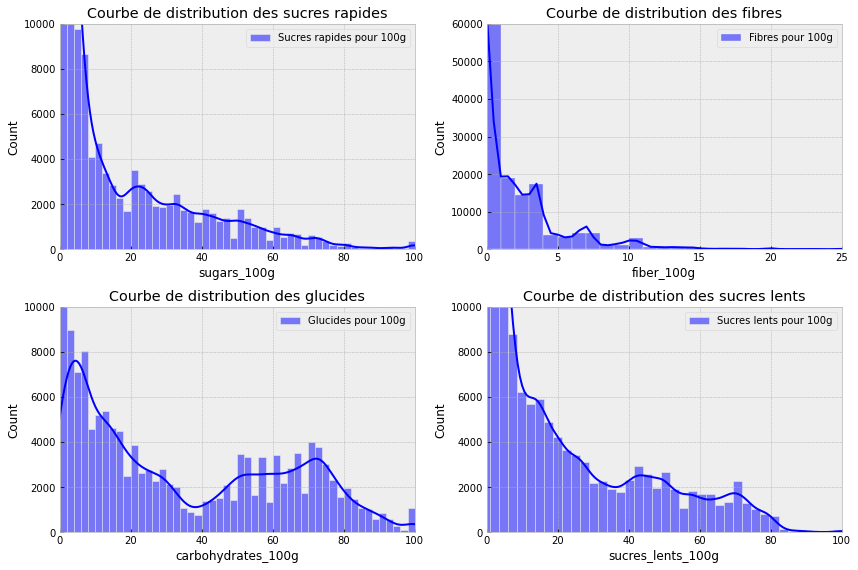

In [17]:
plt.figure(figsize=(12,8)) # figure ration 12:8

# Courbe de distribution du sucre
plt.subplot(2,2,1)
sns.histplot(data['sugars_100g'],label="Sucres rapides pour 100g",kde=True, bins=50,color = 'b' )
plt.title("Courbe de distribution des sucres rapides") # for histogram title
plt.legend() # for label
# control x and y limits
plt.xlim(0, 100)
plt.ylim(0, 10000)
plt.tight_layout(pad = 1)

# Histogramme des fibres
plt.subplot(2,2,2)
sns.histplot(data['fiber_100g'],label="Fibres pour 100g", bins = 100, kde= True,color = 'b' )
plt.title("Courbe de distribution des fibres") # for histogram title
plt.legend() # for label
# control x and y limits
plt.xlim(0, 25)
plt.ylim(0, 60000)
plt.tight_layout(pad = 1)

# Courbe de distribution des glucides
plt.subplot(2,2,3)
sns.histplot(data['carbohydrates_100g'],label="Glucides pour 100g",kde=True, bins=50, color = 'b')
plt.title("Courbe de distribution des glucides") # for histogram title
plt.legend() # for label
# control x and y limits
plt.xlim(0, 100)
plt.ylim(0, 10000)
plt.tight_layout(pad = 1)

# Courbe de distribution des sucres complexes
plt.subplot(2,2,4)
sns.histplot(data['sucres_lents_100g'],label="Sucres lents pour 100g",kde=True, bins=50, color = 'b')
plt.title("Courbe de distribution des sucres lents") # for histogram title
plt.legend() # for label
# control x and y limits
plt.xlim(0, 100)
plt.ylim(0, 10000)
plt.tight_layout(pad = 1)

In [18]:
print("Le skewness pour les sucres rapides est de:\n", data['sugars_100g'].skew())
print("Le skewness pour les fibres est de:\n", data['fiber_100g'].skew())
print("Le skewness pour les sucres lents est de:\n", data['sucres_lents_100g'].skew())

Le skewness pour les sucres rapides est de:
 1.6600704312724208
Le skewness pour les fibres est de:
 4.4360006724801035
Le skewness pour les sucres lents est de:
 1.157182276049402


La distribution de ces trois variables est étalée à droite.

## <span class="bg-info"> 4. Analyse bivariée du jeu de données nettoyé<span>

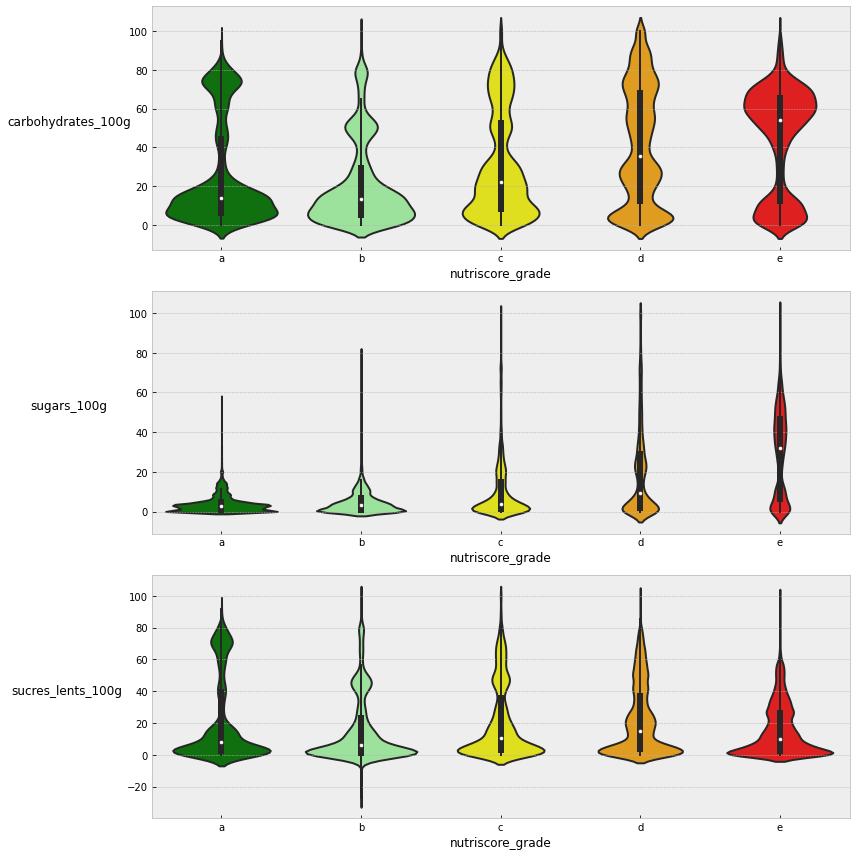

In [19]:
variables_violinplot = ['carbohydrates_100g','sugars_100g','sucres_lents_100g']
fig, ax = plt.subplots(ncols = 1, nrows = 3 , figsize = [12,12])

for i in range(len(variables_violinplot)):    
    var = variables_violinplot[i]   
    # Make a dictionary with one specific color per group:
    my_pal = {"a": "g", "b": "lightgreen", "c":"yellow","d":"orange","e":"red"}
    sns.violinplot(data = data, x = 'nutriscore_grade', y = var, ax = ax[i],palette=my_pal,order= 'abcde')
    ax[i].set_ylabel(var, rotation=0, fontsize=12, labelpad=60)
    plt.tight_layout()

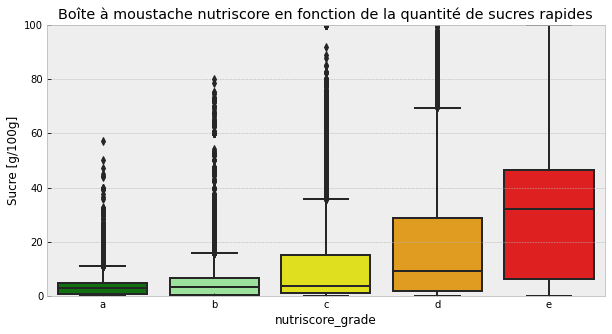

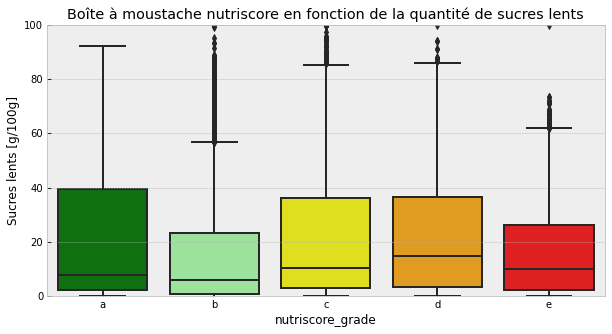

In [20]:
plt.figure(figsize = [10,5])
my_pal = {"a": "g", "b": "lightgreen", "c":"yellow","d":"orange","e":"red"}
sns.boxplot(data = data, x = 'nutriscore_grade', y = 'sugars_100g', palette=my_pal, order= 'abcde')
plt.ylim(0,100)
plt.ylabel('Sucre [g/100g]')
plt.title('Boîte à moustache nutriscore en fonction de la quantité de sucres rapides')

plt.figure(figsize = [10,5])
my_pal = {"a": "g", "b": "lightgreen", "c":"yellow","d":"orange","e":"red"}
sns.boxplot(data = data, x = 'nutriscore_grade', y = 'sucres_lents_100g', palette=my_pal, order= 'abcde')
plt.ylim(0,100)
plt.ylabel('Sucres lents [g/100g]')
plt.title('Boîte à moustache nutriscore en fonction de la quantité de sucres lents')
plt.show()

Les produits avec une grande quantité de sucres rapides ont des mauvaises notes au nutriscore. 

75% des produits notés A et B ont une quantité de sucre < 10g.

Pour une même quantité de sucres complexes, les produits seront partagés sur les différentes notes du nutriscore. 

Une quantité de sucre importante pour 100g de produit est pénalisée dans le calcul du nutriscore ce que nous voyons dans le graphique ci-dessous.

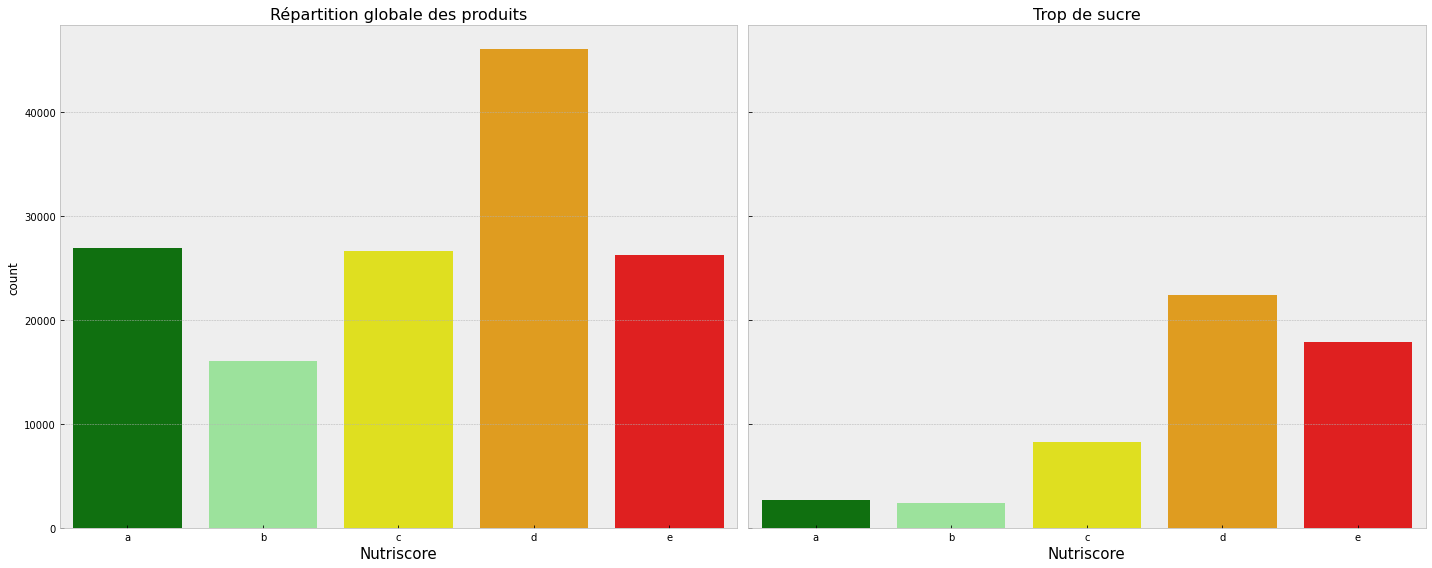

In [21]:
df_trop_sucre = data[data['sugars_100g'] > 10]

plt.rcParams["figure.figsize"] = (20,8)
f, (ax1,ax2) = plt.subplots(1, 2, sharey= True)

ax = sns.countplot(x=data['nutriscore_grade'] , ax = ax1 , order= 'abcde',palette=my_pal)
silent = ax.set_title('Répartition globale des produits',  fontsize=16)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

ax = sns.countplot(x=df_trop_sucre['nutriscore_grade'] , ax = ax2 , order= 'abcde',palette=my_pal)
silent = ax.set_title('Trop de sucre' ,  fontsize=16)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
plt.tight_layout()

## <span class="bg-info"> 5. Analyse multivariée du jeu de données nettoyé<span>

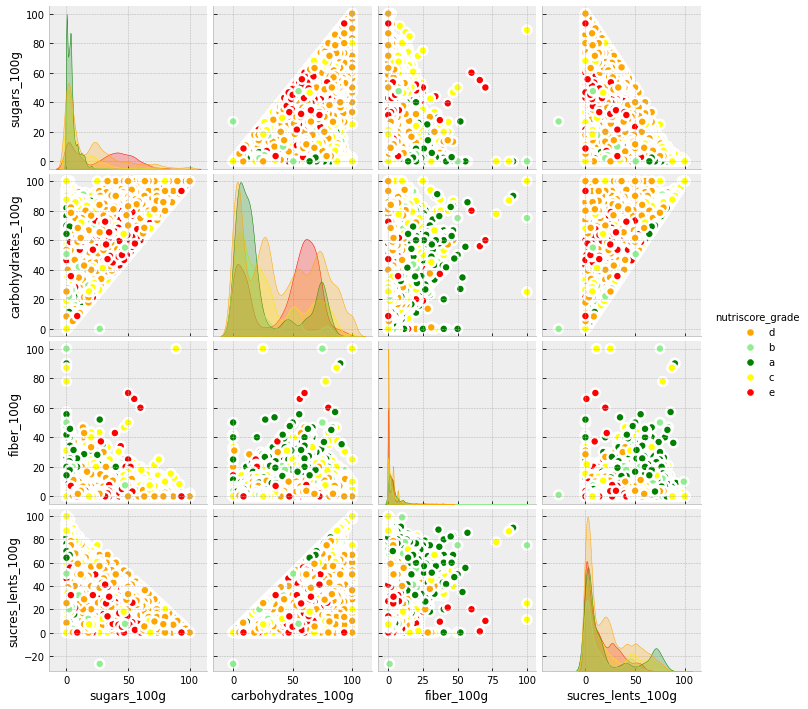

In [22]:
sns.pairplot(data.loc[:,('sugars_100g', 'carbohydrates_100g', 'fiber_100g', 'sucres_lents_100g', 'nutriscore_grade')], kind="scatter", hue="nutriscore_grade", palette = my_pal, plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

In [23]:
data_exemples = data.loc[:,('ratio_sucre', 'nova_group', 'fiber_100g', 'sucres_lents_100g', 'nutriscore_grade')].sample(5000)

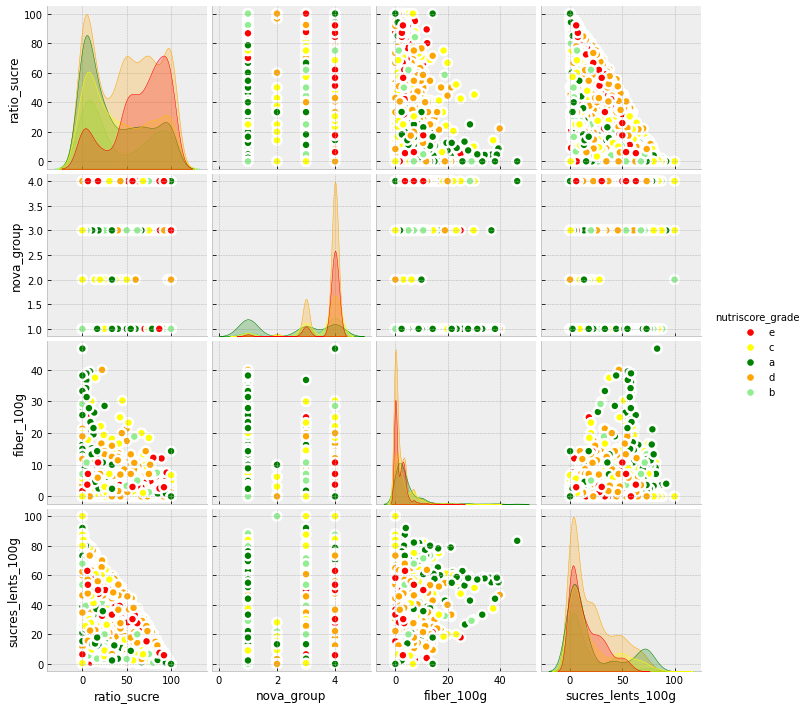

In [24]:
sns.pairplot(data_exemples, kind="scatter", hue="nutriscore_grade", palette = my_pal, plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

In [25]:
data.to_csv('data_application_smart.csv',sep = '\t', encoding='utf_8', index=False)

## <span class="bg-info"> 6. Conclusion <span>

Notre idée d'application est réalisable à partir du jeu de données.

Nous allons créer dans un nouveau notebook (3) __un prototype d'application__.

Nous devrons pour cela __élaborer un score__, qui sera calculé en fonction :

- du nutriscore
- de la classification nova
- du ratio sucres rapides sur sucres lents (variable créée dans le notebook 1)
- de la quantité de fibres

L'application devra __classer en fonction de ce score__ les produits de la base de données correspondants à la recherche d'un utilisateur et conseiller l'utilisateur sur l'adéquation du produit dans le cadre d'un régime alimentaire préconisé en cas de diabète.
